# load packages

In [3]:
using Statistics
using StatsBase
using LinearAlgebra
using DelimitedFiles
using NumericalIntegration
using Plots
plotlyjs()
theme(:juno)

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-13369728649329228042\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6935648485229775625\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-13369728649329228042\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

tpep_dropoff_datetime# load downloaded data + translate into array + save to file
Downloaded from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page \
I'm only using the data from "Yellow Taxi".

An explanation of the data entries is here:
https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

In [22]:
#initialize variables
data=0
distances=0;

In [4]:
for month in 1:12
    
    #load data
    if month<10
        data=readdlm("../../RawData/TaxiNYC/yellow_tripdata_2019-0$(month).csv")
    else
        data=readdlm("../../RawData/TaxiNYC/yellow_tripdata_2019-$(month).csv")
    end

    #get distances
    distances=zeros(length(data[2:end,3]))
    for jj in 1:length(data[2:end,3])
        str=data[1+jj,3]
        mys=""
        count=0
        for ind in 1:length(str)
            sym=str[ind]
            if sym==','
                count+=1
                continue
            end
            if count==2
                mys*=sym
            elseif count == 3
                break
            end
        end
        distances[jj]=parse(Float64,mys)
    end

    #get start+end times
    timeStart=zeros(length(data[2:end,2]))
    timeEnd=zeros(length(data[2:end,2]))
    for jj in 1:length(data[2:end,2])
        str=data[1+jj,2]
        timeStart[jj]=parse(Float64,str[1:2])*60+parse(Float64,str[4:5])
        str=data[1+jj,3]
        timeEnd[jj]=parse(Float64,str[1:2])*60+parse(Float64,str[4:5])
    end

    #save to variables
    if month<10
        myCode="d0$(month)=distances;t10$(month)=timeStart;t20$(month)=timeEnd"
    else
        myCode="d$(month)=distances;t1$(month)=timeStart;t2$(month)=timeEnd"
    end
    eval(Meta.parse(myCode))

    #proudly announce progress
    println("month $(month) done.")
    
end

LoadError: UndefVarError: distances not defined

#### write distances to files

In [3]:
for month in 1:12
    if month<10
        myCode="writedlm(\"distances/d0$(month)\",d0$(month))"
    else
        myCode="writedlm(\"distances/d$(month)\",d$(month))"
    end
    eval(Meta.parse(myCode))
end

LoadError: UndefVarError: d01 not defined

#### write times to files

In [177]:
for month in 1:12
    if month<10
        myCode="writedlm(\"times/t10$(month)\",t10$(month));writedlm(\"times/t20$(month)\",t20$(month))"
    else
        myCode="writedlm(\"times/t1$(month)\",t1$(month));writedlm(\"times/t2$(month)\",t2$(month))"
    end
    eval(Meta.parse(myCode))
end

# distances

#### read distances from files

In [288]:
for month in 1:12
    if month<10
        myCode="d0$(month)=readdlm(\"distances/d0$(month)\")"
    else   
        myCode="d$(month)=readdlm(\"distances/d$(month)\")"     
    end
    eval(Meta.parse(myCode))
end

#### combine distances into one array

In [289]:
distances=vcat(d01,d02,d03,d04,d05,d06,d07,d08,d09,d10,d11,d12)[:];

#### histogram

In [347]:
dataset=distances
min=0
max=50
Δ=0.1
bins=collect(min:Δ:max)
h=normalize(fit(Histogram, dataset, bins,closed=:right),mode=:pdf)
x=h.edges[1]
x=0.5*(x[1:end-1]+x[2:end])
y=h.weights;

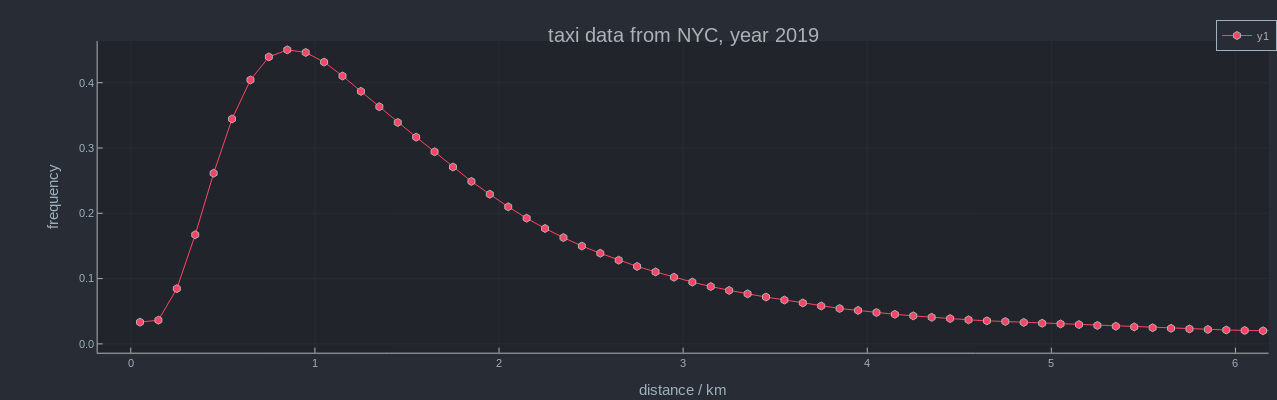

In [349]:
plot(x,y,xlim=[0,6],marker=:hex,xlab="distance / km",ylab="frequency",title="taxi data from NYC, year 2019")

In [343]:
savefig("traveldistancesHistogramNYC2019.html")

#### remaining passengers after certain distance

In [353]:
Γ=zeros(length(y))
temp=y./x
for z in 1:length(Γ)
    Γ[z]=integrate(x[z:end],temp[z:end])
end
F=cumul_integrate(x,-Γ).+1;

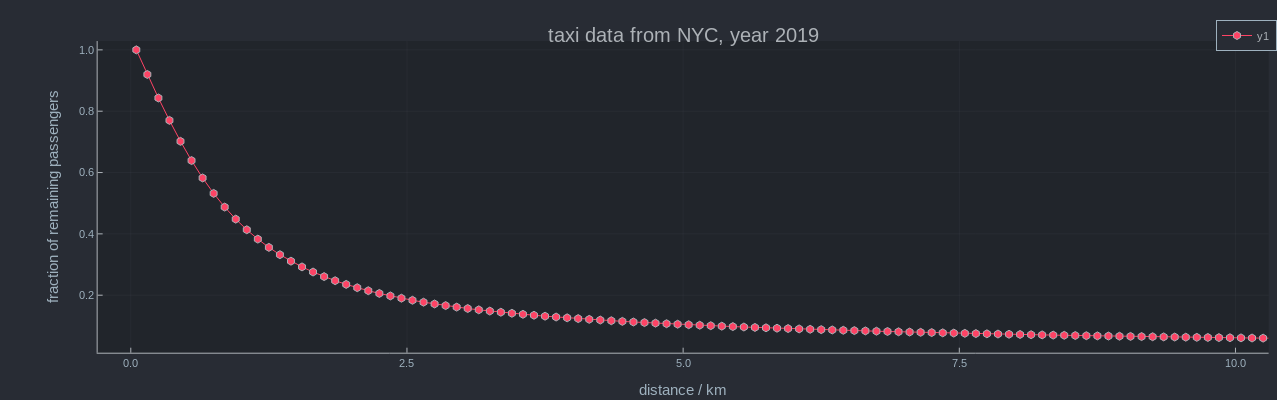

In [355]:
plot(x,F,xlim=[0,10],marker=:hex,xlab="distance / km",ylab="fraction of remaining passengers",title="taxi data from NYC, year 2019")

#### analytic approximation

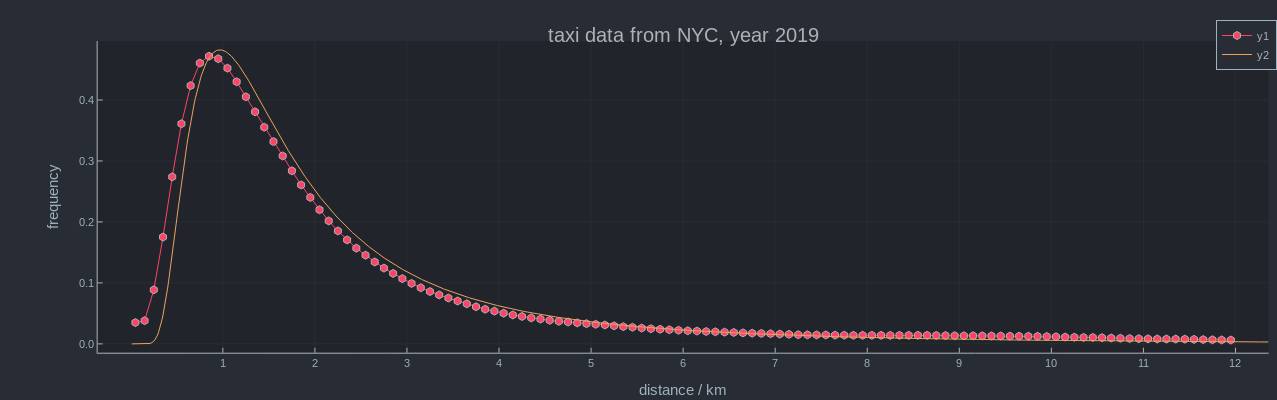

In [170]:
D=mean(distances)
k=3.1
x=Array(0.01:0.01:20)
y=exp.(-(x./D).^-1).*((x./D).^-k)
y./=sum(y)*0.01
plot!(x,y,xlim=[0,12],xlab="distance / km",ylab="frequency",title="taxi data from NYC, year 2019",xticks=1:50)

#### integral distribution
..but *-1 +1

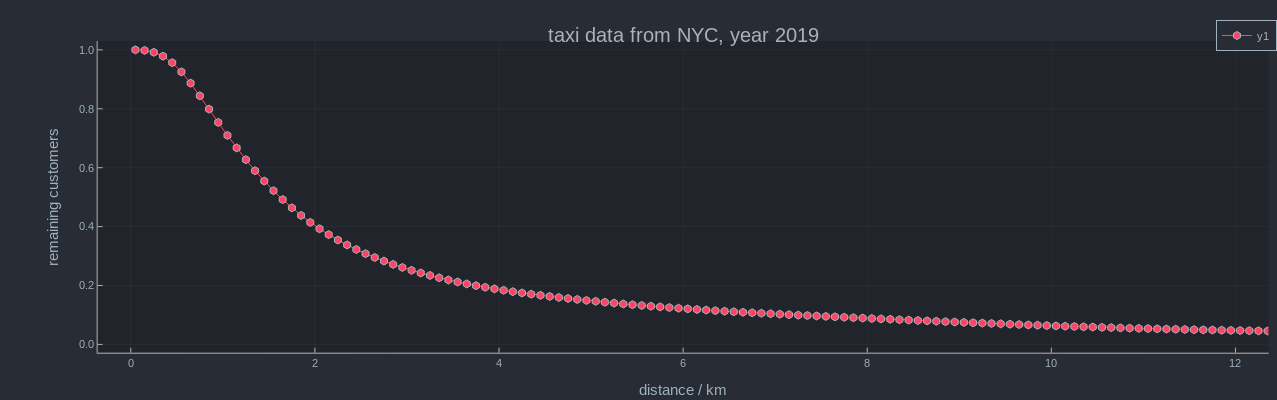

In [273]:
plot(x,cumul_integrate(x,-y).+1,marker=:hex,xlim=[0,12],xlab="distance / km",ylab="remaining customers",title="taxi data from NYC, year 2019",xticks=0:2:100,yticks=0:0.2:1)

#### log-log histogram

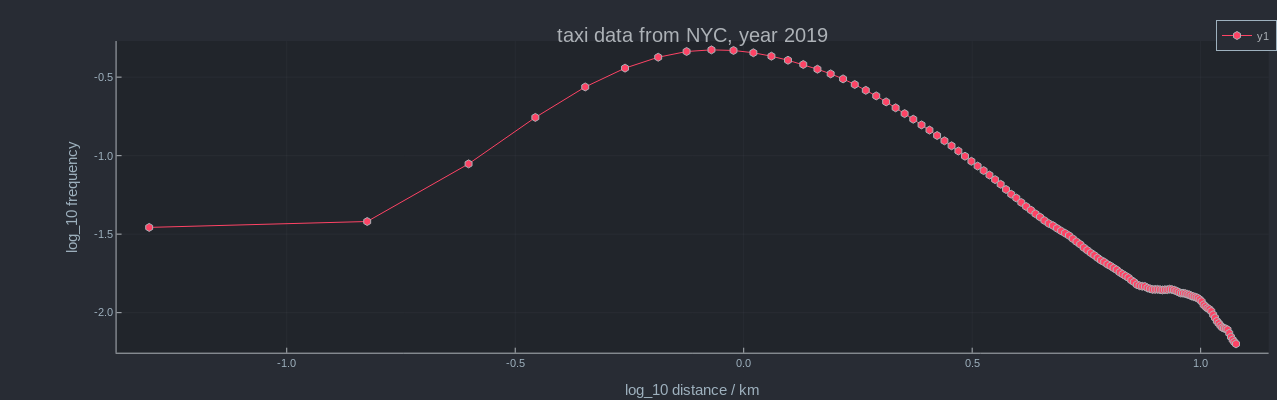

In [172]:
#log-log
logX=log.(10,x)
logY=log.(10,y)
plot(logX,logY,marker=:hex,xlab="log_10 distance / km",ylab="log_10 frequency",title="taxi data from NYC, year 2019")

#### power law exponent - rough estimate

In [345]:
right=300
left=50
(logY[right]-logY[left])/(logX[right]-logX[left])

-3.1900103156234354

# travel times

#### read times from files

In [178]:
for month in 1:12
    if month<10
        myCode="t10$(month)=readdlm(\"times/t10$(month)\");t20$(month)=readdlm(\"times/t20$(month)\")"
    else   
        myCode="t1$(month)=readdlm(\"times/t1$(month)\");t2$(month)=readdlm(\"times/t2$(month)\")"
    end
    eval(Meta.parse(myCode))
end

#### combine times into one array

In [179]:
t1=vcat(t101,t102,t103,t104,t105,t106,t107,t108,t109,t110,t111,t112)[:];

In [180]:
t2=vcat(t201,t202,t203,t204,t205,t206,t207,t208,t209,t210,t211,t212)[:];

#### histogram

In [358]:
dataset=t1
min=0
max=1439
Δ=1
bins=collect(min:Δ:max)
h=normalize(fit(Histogram, dataset, bins,closed=:right),mode=:pdf)
x=h.edges[1]
x=0.5*(x[1:end-1]+x[2:end])
y=h.weights;

#### start times

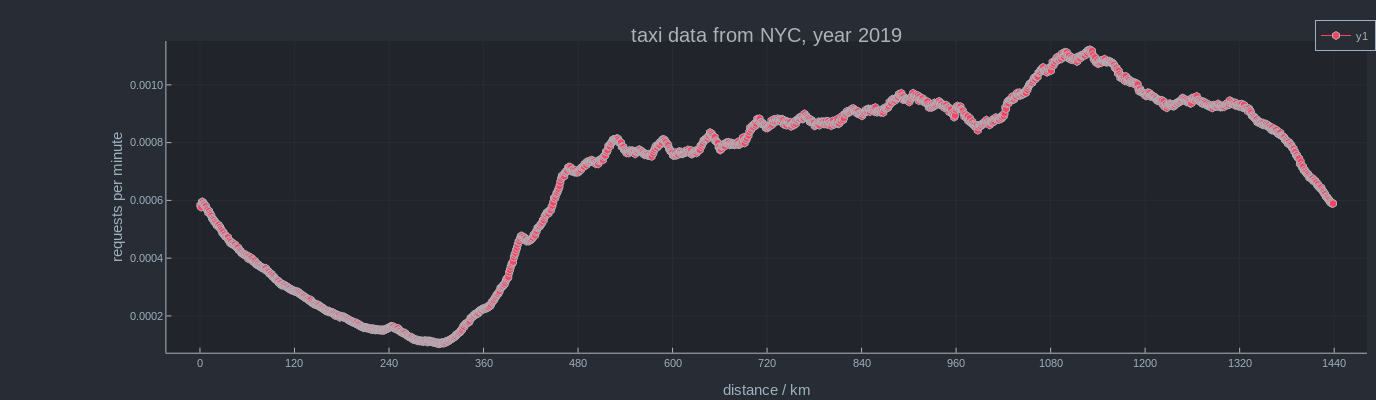

In [359]:
plot(x,y,marker=:hex,xlab="distance / km",ylab="requests per minute",title="taxi data from NYC, year 2019",xticks=0:120:1440)

In [161]:
savefig("startTimesHistogramNYC2019.html")

#### travel times

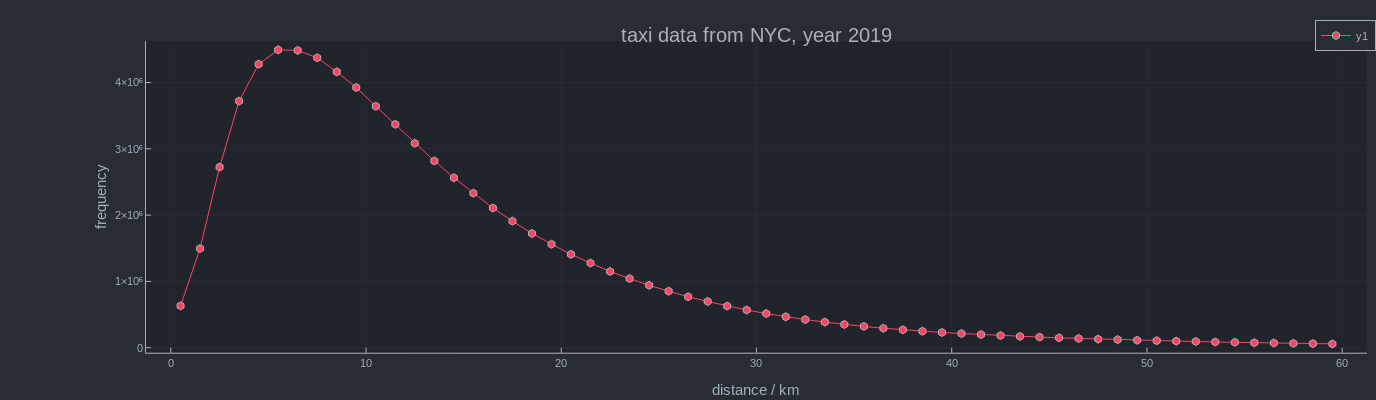

In [184]:
plot(x,y,marker=:hex,xlab="distance / km",ylab="frequency",title="taxi data from NYC, year 2019")